# Image Segmentation with CAMVID Dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

from skimage.io import imread, imshow

from fastai.vision import get_image_files, open_image, open_mask, URLs, untar_data
from fastai.vision import get_transforms, error_rate, lr_find, unet_learner, defaults, imagenet_stats
from fastai.vision import models as vision_models
from fastai.vision import SegmentationItemList, DatasetType
from fastai.utils.mem import gpu_mem_get_free_no_cache

### Unloading data to OS default path

In [2]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/camvid/images'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/valid.txt')]

In [3]:
path_lbl = path/'labels'
path_img = path/'images'

In [4]:
image_files = get_image_files(path_img)
image_files[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/images/0001TP_008160.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0016E5_08041.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0006R0_f02340.png')]

In [5]:
label_files = get_image_files(path_lbl)
label_files[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_05400_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0006R0_f02640_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_05340_P.png')]

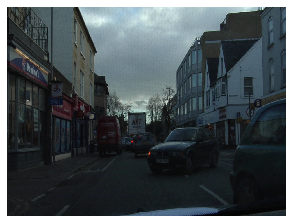

In [6]:
img = open_image(image_files[0])
img.show(figsize=(5,5))

In [7]:
# https://realpython.com/python-pathlib/

get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

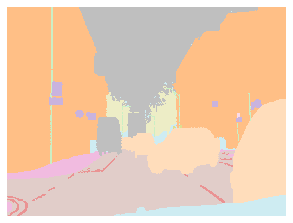

In [8]:
img = open_mask(get_y_fn(image_files[0]))
img.show(figsize=(5,5))

In [9]:
# Mask file peek

imread(get_y_fn(image_files[0]))

Array([[ 4,  4,  4,  4, ...,  4,  4,  4,  4],
       [ 4,  4,  4,  4, ...,  4,  4,  4,  4],
       [ 4,  4,  4,  4, ...,  4,  4,  4,  4],
       [ 4,  4,  4,  4, ...,  4,  4,  4,  4],
       ...,
       [17, 17, 17, 17, ..., 30, 30, 30, 30],
       [17, 17, 17, 17, ..., 30, 30, 30, 30],
       [17, 17, 17, 17, ..., 30, 30, 30, 30],
       [17, 17, 17, 10, ..., 30, 30, 30, 30]], dtype=uint8)

In [10]:
# The targets are as per indics in codes

codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [11]:
valid = np.loadtxt(path/'valid.txt', dtype=str)
valid

array(['0016E5_07959.png', '0016E5_07961.png', '0016E5_07963.png', '0016E5_07965.png', ..., '0016E5_08153.png',
       '0016E5_08155.png', '0016E5_08157.png', '0016E5_08159.png'], dtype='<U16')

### Creating Dataset

In [12]:
free = gpu_mem_get_free_no_cache()
print(f"Using {free} MB of GPU RAM")

Using 11430 MB of GPU RAM


In [13]:
data_source = (SegmentationItemList.from_folder(path_img).split_by_fname_file('../valid.txt').label_from_func(get_y_fn, classes=codes))
data_source

LabelLists;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/ubuntu/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/ubuntu/.fastai/data/camvid/images;

Test: None

In [14]:
bs = 8
size = np.array(data_source.train.x[0].shape[1:])

In [15]:
dataset = (data_source.transform(get_transforms(), size=size // 2, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

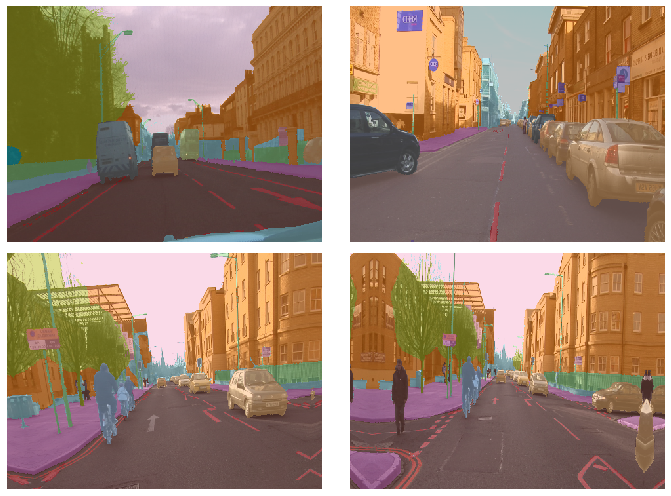

In [16]:
dataset.show_batch(2, figsize=(10, 7))

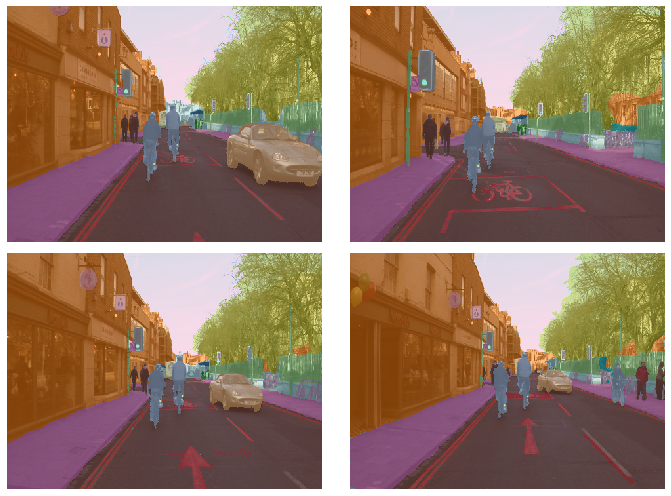

In [19]:
dataset.show_batch(2, figsize=(10, 7), ds_type=DatasetType.Valid)

### Modelling

### Round 1

In [15]:
# Fitness function as is

name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [23]:
learn = unet_learner(dataset, vision_models.resnet34, metrics=[acc_camvid], wd=0.01)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04
Min loss divided by 10: 1.58E-03


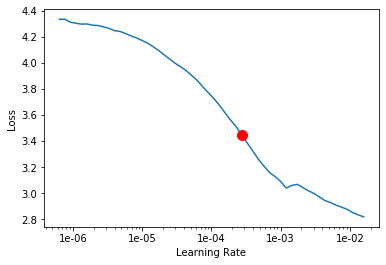

In [24]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [25]:
# More about pct_start on below link
# https://forums.fast.ai/t/what-is-the-pct-start-mean/26168/6


lr = 2.75E-04 
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.142487,1.469364,0.647164,03:25
1,1.303751,0.835411,0.808473,03:16
2,0.963768,0.712440,0.826643,03:15
3,0.771689,0.612473,0.842826,03:15
4,0.686462,0.601421,0.839070,03:15
5,0.624292,0.503682,0.857192,03:14
6,0.557610,0.422239,0.878783,03:14
7,0.543822,0.426640,0.877714,03:15
8,0.507754,0.364013,0.893772,03:15
9,0.439210,0.338275,0.903571,03:15


In [26]:
learn.save('stage-1')

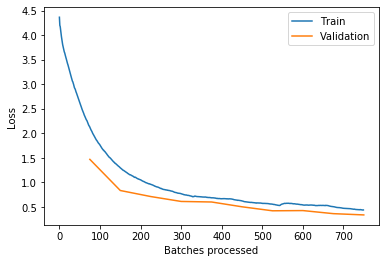

In [32]:
learn.recorder.plot_losses()

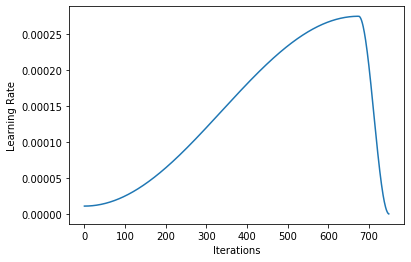

In [33]:
learn.recorder.plot_lr() # 80% increase, 20% decrease during one cycle

In [27]:
learn.load('stage-1');

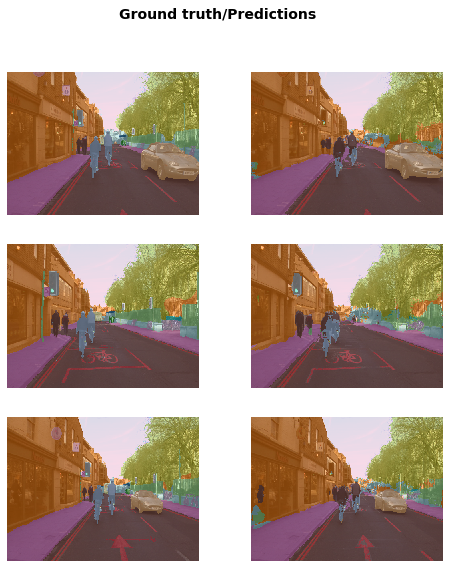

In [28]:
# Note the use of "show_results" method

learn.show_results(rows=3, figsize=(8,9))

### Round 2

In [29]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 1.00E-06


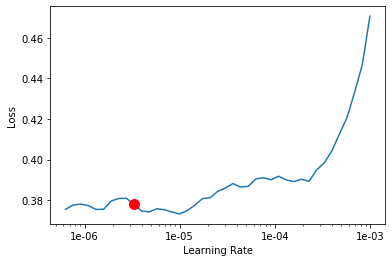

In [34]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [36]:
lrs = slice(lr/400, lr/4)
lrs

slice(6.875000000000001e-07, 6.875e-05, None)

In [37]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.380621,0.328652,0.905142,03:21
1,0.375495,0.327079,0.906207,03:23
2,0.372223,0.323145,0.905789,03:22
3,0.370130,0.322352,0.906301,03:22
4,0.364882,0.309230,0.910943,03:22
5,0.356450,0.329408,0.903439,03:23
6,0.346087,0.308908,0.910648,03:23
7,0.341998,0.310465,0.910326,03:22
8,0.328801,0.333191,0.904930,03:22
9,0.318520,0.303043,0.912874,03:23


In [38]:
learn.save('stage-2');

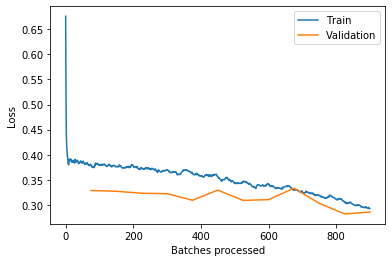

In [39]:
learn.recorder.plot_losses()

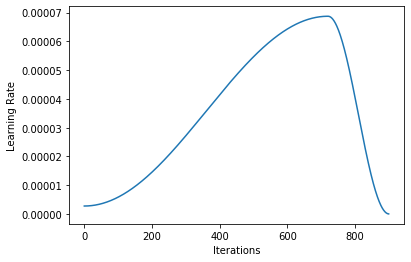

In [40]:
learn.recorder.plot_lr()

### Round 3

Kernel restart required here before proceeding

In [16]:
dataset_large = (data_source.transform(get_transforms(), size=size, tfm_y=True).databunch(bs=2).normalize(imagenet_stats))
dataset_large

ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/ubuntu/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/ubuntu/.fastai/data/camvid/images;

Test: None

In [17]:
learn = unet_learner(dataset_large, vision_models.resnet34, metrics=[acc_camvid], wd=1e-2)

In [18]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


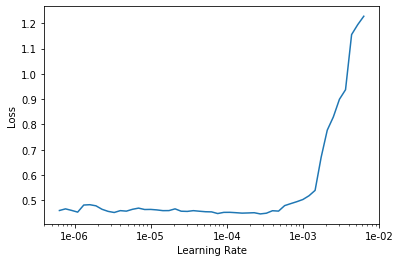

In [19]:
lr_find(learn)
learn.recorder.plot()

In [20]:
# Interrupted due to long wait hours...

lr=1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.418801,0.315902,0.909660,14:30
1,0.399871,0.330780,0.906353,14:16


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-1d656037818b>", line 2, in <module>
    learn.fit_one_cycle(10, slice(lr), pct_start=0.8)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/train.py", line 23, in fit_one_cycle
    learn.fit(cyc_len, max_lr, wd=wd, callbacks=callbacks)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py", line 200, in fit
    fit(epochs, self, metrics=self.metrics, callbacks=self.callbacks+callbacks)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py", line 101, in fit
    loss = loss_batch(learn.model, xb, yb, learn.loss_func, learn.opt, cb_handler)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py", line 35, in loss_batch
    if not cb_handler.on_backward_end(): opt.st

KeyboardInterrupt: 

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_lr()

### Round 4

In [ ]:
learn.unfreeze()

In [ ]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [ ]:
lrs = slice(1e-6, lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_lr()

In [ ]:
# Note the use of "show_results" method

learn.show_results(rows=3, figsize=(8,9))